# Interactive Structured Bond

In this interactive notebook (created with Python and Jupyter) we take a look at the performance of a structured finance deal under various degrees of stress.

A typical deal structure would hold an underlying asset (e.g. a portfolio of Receivables, Non-Performing Loans or Real Estate) that forms the basis for the transaction and is the generator of cash flows.

## Deal structure
By taking into account the objectives of the various potential investors it is possible to come up with a structure that would be satisfactory to all parties. 

In particular prudent investors would like to receive their share of the anticipated returns and the associated cash flows first in line ("Senior"). This could be achieved by assigning the largest part of cash to first to Senior tranches and thereafter to Junior noteholders and lastly Equity to the more risk- tolerant investors.

This process of assigning cash flows sequentially is called a "Waterfall"; Imagine a waterbed in which the water flowing over (and filling up) first interest payments, then amortising the upper (senior) echelons and later the more junior and downriver sections.

Of course there are many possible technicalities to a deal including paydown mechanics (sequential, pro-rata) and other items in the waterfall (expenses, liquidity providers) but the main principle is to allocate or "tranche" the available cash flows as described above. Certain transactions also get assigned a standardised level of perceived riskyness (e.g. "triple-A" or "single-B") by rating agencies.

## Scenarios
When structuring a deal you would run many simulations to assess how well it would perform under various scenarios such as fall in asset value, delay to collections.

In this in interactive example we have three classes of bonds to be paid down in sequence starting with the most senior "A" tranche which (as it is the least risky pays the least interest amount). Subsequently what is left of cash flows goes to equity (one could assume that the most junior pieces would be kept with the deal originator keeping its skin in the game).

Specifically in this example we have the following tranche sizes: A 60%, B 30% and Junior 10%.
Interest rates (increase with level of risk): A 5%, B 7% and Junior 12%.


## Interactive model
By moving the sliders (see technical note) below you can explore what effect loss in value and/or delays have to the paydown of the principal and the income to equity in a typical deal. Note that when there is not enough cash to pay interest (top priority) in a period, the missing amount would be capitalised (added to the corresponding bond tranche).


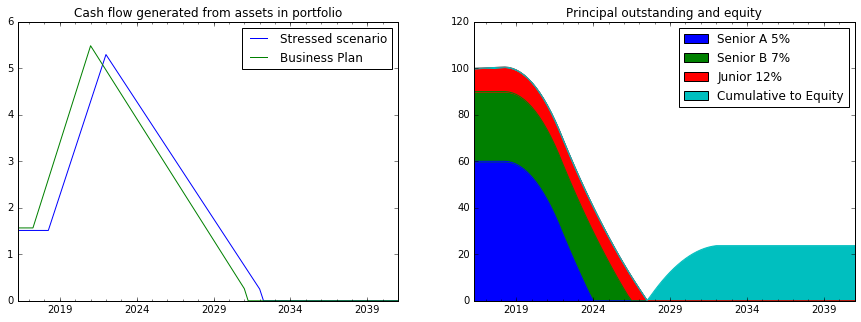

In [28]:
%matplotlib inline
import matplotlib
import datetime
from dateutil import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

#interest rates (divide by four as quarterly used)
int_rate=np.array([0.05,0.07,0.12])/4
#amort_rate=[0.1,0.08,0.04]
noBondClasses=3
nper=100; #number of periods

def koko(Asset_Valuation,Delay_to_Sales):
    #Inititate the capital in the three bond tranches
    bondTranches = np.array([np.zeros(nper)]*noBondClasses*4).T
      
    bondTranches[0,3]=60.0;
    bondTranches[0,7]=30;
    bondTranches[0,11]=10;
    
    def salesProfile(Delay_to_Sales,Asset_Valuation):
    # generate cash flow profile
        cashIn = np.array([np.zeros(nper)]).T
        for per in range(0,nper//20+Delay_to_Sales):
            cashIn[per]=6;
        for per in range(nper//20+Delay_to_Sales,nper//5+Delay_to_Sales):
            cashIn[per]=cashIn[per-1]+1;
        for per in range(nper//5+Delay_to_Sales,3*nper//5+Delay_to_Sales):    
            cashIn[per]=max(0,cashIn[per-1]-0.5);
        cashIn/=cashIn.sum()
        cashIn*=Asset_Valuation;
        return cashIn;
  
    
    cashOut = np.array([np.zeros(nper)]).T;
    cashIn=salesProfile(Delay_to_Sales,Asset_Valuation);
  
    
    def calcAmort(nper): 

        for per in range(1,nper):
            freeCash=cashIn[per].copy()
            
            #interest due class A
            bondTranches[per,0]=bondTranches[per-1,3]*int_rate[0];
            #interest paid class A
            bondTranches[per,1]=min(freeCash,bondTranches[per,0]);
            freeCash-=bondTranches[per,1];
            #interest capitalised in period class A
            bondTranches[per,2]=bondTranches[per,0]-bondTranches[per,1];
 
            #interest due class B
            bondTranches[per,4]=bondTranches[per-1,7]*int_rate[1];
            #interest paid class B
            bondTranches[per,5]=min(freeCash,bondTranches[per,4]);
            freeCash-=bondTranches[per,5]
            #interest capitalised in period class B
            bondTranches[per,6]=bondTranches[per,4]-bondTranches[per,5];
            
            #interest due class Jr
            bondTranches[per,8]=bondTranches[per-1,11]*int_rate[2];
            #interest paid class Jr
            bondTranches[per,9]=min(freeCash,bondTranches[per,8]);
            freeCash-=bondTranches[per,9]
            #interest capitalised in period class Jr
            bondTranches[per,10]=bondTranches[per,8]-bondTranches[per,9]
            
            #amortisation class A
            #amortDue=bondTranches[per-1,3]*amort_rate[0];
            amortDue=bondTranches[per-1,3];
            amortPaid=min(freeCash,amortDue)
            bondTranches[per,3]=bondTranches[per-1,3]-amortPaid+bondTranches[per,2]
            freeCash-=amortPaid
 
            #amortisation class B
            #amortDue=bondTranches[per-1,7]*amort_rate[1];
            amortDue=bondTranches[per-1,7];
            amortPaid=min(freeCash,amortDue)
            bondTranches[per,7]=bondTranches[per-1,7]-amortPaid+bondTranches[per,6]
            freeCash-=amortPaid
            
            #amortisation class Jr
            amortDue=bondTranches[per-1,11];
            amortPaid=min(freeCash,amortDue)
            bondTranches[per,11]=bondTranches[per-1,11]-amortPaid+bondTranches[per,10];
            freeCash-=amortPaid
            cashOut[per]=cashOut[per-1]+freeCash;
            #bondTranches[per,2]=-min(cashIn[per],bondTranches[per,0],bondTranches[0,3]*amort_rate[0]);



    calcAmort(nper);


    todays_date = datetime.datetime.now().date()
    index = pd.date_range(todays_date-datetime.timedelta(10), periods=nper, freq='Q')
    columns = ['IntDueA','IntPaidA','IntCapA', 'Senior A 5%','IntDueB','IntPaidB','IntCapB', 'Senior B 7%','IntDueJr','IntPaidJr','IntCapJr', 'Junior 12%']
    df = pd.DataFrame( bondTranches, index=index, columns=columns)
    df['Cumulative to Equity']=cashOut
    
    businessPlan=salesProfile(0,175);
    cashFlows = pd.DataFrame( cashIn, index=index, columns=['Stressed scenario']);
    cashFlows['Business Plan']=businessPlan;

    fig, axs = plt.subplots(1,2)


    df.loc[:,['Senior A 5%','Senior B 7%','Junior 12%','Cumulative to Equity']].plot(kind='area',stacked=True,ax=axs[1], figsize=(15, 5),title="Principal outstanding and equity")
   
   
    cashFlows.plot(ax=axs[0],title="Cash flow generated from assets in portfolio");


  
interact(koko,Asset_Valuation=(150,200,5),Delay_to_Sales=(-4,12,2));



In the first scenario (above) which simulates a minor delay (four quarters) in cash flow profile
all the 100 units of debt tranches are paid down in full sequentially. 
Thereafter approx 30 units are accumulated to equity between 2027 and 2031.

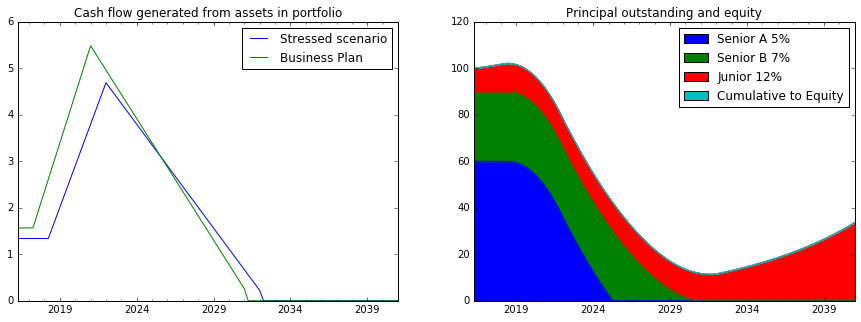

In [29]:
interact(koko,Asset_Valuation=(130,180,5),Delay_to_Sales=(-4,12,2));

In the second scenario (above) which simulates a decrease in portfolio valuation of some 12%
only the senior 90 units (A and B) of debt tranches are paid down. 
There is not enough cash available to pay off the junior 10 units which start to increase
(through capitalised interest) in 2031. Of course there will be no flow to equity in this case.

## Technical note
*As of writing (Jan 2018) interactivity in this application type (ipywidgets) is not yet available over the web. Until that functionality becomes live you would need to download and install the open source notebook Jupyter from url('http://jupyter.org') to your machine in order to be able to have access to the sliders and full interactivity.